In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


# Ajouter arch pour le modèle GARCH
from arch import arch_model

# Calcul des métriques d'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df=pd.read_csv("/Users/aroldtoubert/Downloads/data_macro_romain_processed.csv")

In [3]:
df.head()

,date,return_eurousd,return_sp500,return_dax,return_sofr,return_ester,return_BEIR_10Y_US,return_BEIR_10Y_EU,return_Spread_rate,return_Spread_inflation
0,2019-01-02,-0.002732,0.001268,0.002009,0.050000,-0.034483,-0.005848,-0.018884,0.038684,0.022018
1,2019-01-03,-0.012608,-0.025068,-0.015577,-0.142857,0.002232,-0.011765,-0.004374,-0.124792,-0.026930
2,2019-01-04,0.006427,0.033759,0.033144,-0.092593,0.000000,0.047619,0.007909,-0.079390,0.130996
3,2019-01-07,0.001699,0.006986,-0.001848,-0.016327,0.002227,0.011364,0.014821,-0.013453,0.004894
4,2019-01-08,0.006054,0.009649,0.005213,0.004149,0.000000,0.022472,0.021478,0.003497,0.024351


In [66]:
# Calcul de la volatilité historique (HV) sur une fenêtre de 30 jours
def calculate_historical_volatility(returns, window=30):
    """
    Calcule la volatilité historique comme dans l'article de Lahmiri
    """
    # Calculer la volatilité comme l'écart-type sur une fenêtre glissante de 30 jours
    # et annualiser (sqrt(252) est un facteur d'annualisation commun pour les données quotidiennes)
    hvol = returns.rolling(window=window).std() * np.sqrt(252)
    return hvol

# Données de retours déjà calculées
returns = df['return_eurousd']

# 1. Calculer la volatilité historique
hv = calculate_historical_volatility(returns)
df['historical_volatility'] = hv

df.head()

,date,return_eurousd,return_sp500,return_dax,return_sofr,return_ester,return_BEIR_10Y_US,return_BEIR_10Y_EU,return_Spread_rate,return_Spread_inflation,historical_volatility
0,2019-01-02,-0.002732,0.001268,0.002009,0.050000,-0.034483,-0.005848,-0.018884,0.038684,0.022018,NaN
1,2019-01-03,-0.012608,-0.025068,-0.015577,-0.142857,0.002232,-0.011765,-0.004374,-0.124792,-0.026930,NaN
2,2019-01-04,0.006427,0.033759,0.033144,-0.092593,0.000000,0.047619,0.007909,-0.079390,0.130996,NaN
3,2019-01-07,0.001699,0.006986,-0.001848,-0.016327,0.002227,0.011364,0.014821,-0.013453,0.004894,NaN
4,2019-01-08,0.006054,0.009649,0.005213,0.004149,0.000000,0.022472,0.021478,0.003497,0.024351,NaN


In [67]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
# Tester la stationnarité des rendements
test_stationarity(returns)

ADF Statistic: -38.36812652883111
p-value: 0.0
Critical Values:
	1%: -3.4346006335993753
	5%: -2.8634173941776297
	10%: -2.5677694956796304


In [ ]:


# Fonction pour calculer et ajuster le modèle GARCH(1,1)
def fit_model(returns, model_type='Garch', distribution='StudentsT'):

    # Supprimer les valeurs NA
    returns = returns.dropna()
    
    # Rescaler les returns
    scaled_returns = returns * 100
    
    # Configurer le modèle en fonction du type
    if model_type.upper() == 'GJR-GARCH':
        model = arch_model(scaled_returns,
                         vol='GARCH',
                         p=1,
                         q=1,
                         o=1,  # Active le terme asymétrique pour GJR-GARCH
                         power=2.0,  # Power GARCH avec puissance 2 pour GJR-GARCH
                         dist=distribution)
    else:
        model = arch_model(scaled_returns,
                         vol=model_type,
                         p=1,
                         q=1,
                         o=1 if model_type=='EGARCH' else 0,
                         dist=distribution)
    
    # Ajuster le modèle
    results = model.fit(disp='off')
    
    # Obtenir les prévisions de volatilité
    volatility = pd.Series(
        np.sqrt(results.conditional_volatility) * np.sqrt(252) / 100,
        index=returns.index
    )
    
    return results, volatility




In [69]:
# Ajouter après avoir chargé et préparé vos données
# Supposons que 'returns' est votre série de rendements

# Déterminer le point de séparation à 80%
split_point = int(len(returns) * 0.8)

# Créer les ensembles d'entraînement et de test
train_returns = returns.iloc[:split_point]
test_returns = returns.iloc[split_point:]

print(f"Taille de l'ensemble d'entraînement: {len(train_returns)}")
print(f"Taille de l'ensemble de test: {len(test_returns)}")

Taille de l'ensemble d'entraînement: 1233
Taille de l'ensemble de test: 309


In [58]:
model_metrics = {}
for model_type in ['Garch', 'EGARCH', 'GJR-GARCH']:
    for dist in ['Normal', 'StudentsT', 'ged']:
        try:
            result, _ = fit_model(train_returns, model_type=model_type, distribution=dist)
            model_metrics[(model_type, dist)] = {
                'AIC': result.aic,
                'BIC': result.bic,
                'Log-Likelihood': result.loglikelihood
            }
        except:
            print(f"Erreur avec {model_type}, {dist}")

Meilleur modèle selon AIC: ('Garch', 'StudentsT')
Test de normalité des résidus: statistique=40.395649137336434, p-value=1.6912049588498075e-09


<Figure size 1200x600 with 0 Axes>

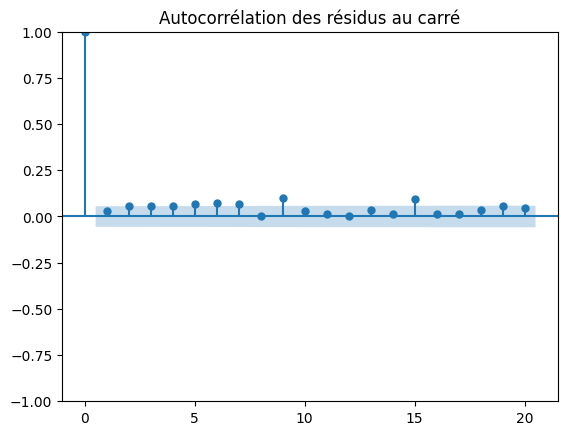

In [59]:
model_comparison = pd.DataFrame(model_metrics).T
best_model = model_comparison['AIC'].idxmin()
print(f"Meilleur modèle selon AIC: {best_model}")

# Analyse des résidus pour le meilleur modèle
best_result, _ = fit_model(train_returns, model_type=best_model[0], distribution=best_model[1])
residuals = best_result.resid / np.sqrt(best_result.conditional_volatility)

# Test de normalité
from scipy import stats
k2, p = stats.normaltest(residuals)
print(f"Test de normalité des résidus: statistique={k2}, p-value={p}")

# Autocorrélation des résidus
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plot_acf(residuals**2, lags=20)
plt.title('Autocorrélation des résidus au carré')
plt.show()

<Figure size 1200x600 with 0 Axes>

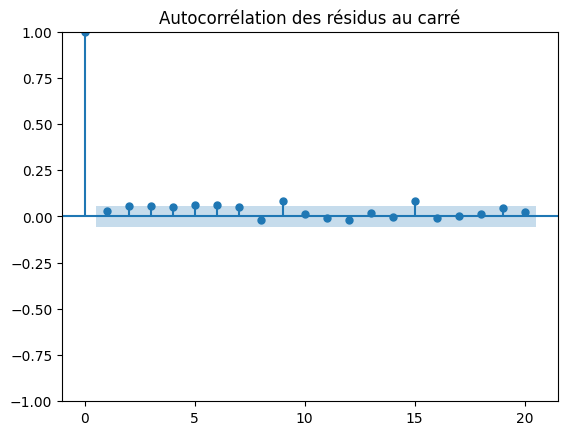

In [61]:
plt.figure(figsize=(12, 6))
plot_pacf(residuals**2, lags=20)
plt.title('Autocorrélation des résidus au carré')
plt.show()

In [60]:
def find_best_order(returns, max_p=3, max_q=3, model_type='Garch', distribution='StudentsT'):
    best_aic = np.inf
    best_bic = np.inf
    best_order_aic = (0, 0)
    best_order_bic = (0, 0)
    
    results = {}
    
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:
                # Supprimer les valeurs NA
                scaled_returns = returns.dropna() * 100
                
                model = arch_model(scaled_returns,
                                 vol=model_type,
                                 p=p,
                                 q=q,
                                 o=1 if model_type=='EGARCH' else 0,
                                 dist=distribution)
                
                fitted = model.fit(disp='off')
                
                results[(p, q)] = {
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'Log-Likelihood': fitted.loglikelihood
                }
                
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order_aic = (p, q)
                
                if fitted.bic < best_bic:
                    best_bic = fitted.bic
                    best_order_bic = (p, q)
                    
            except Exception as e:
                print(f"Erreur pour p={p}, q={q}: {e}")
                results[(p, q)] = {'AIC': np.nan, 'BIC': np.nan, 'Log-Likelihood': np.nan}
    
    # Transformer en DataFrame pour une meilleure visualisation
    results_df = pd.DataFrame(results).T
    results_df.index.names = ['p', 'q']
    
    print(f"Meilleur ordre selon AIC: GARCH({best_order_aic[0]},{best_order_aic[1]})")
    print(f"Meilleur ordre selon BIC: GARCH({best_order_bic[0]},{best_order_bic[1]})")
    
    return results_df, best_order_aic, best_order_bic

# Utilisation
results_df, best_aic_order, best_bic_order = find_best_order(train_returns, max_p=3, max_q=3)

Meilleur ordre selon AIC: GARCH(1,1)
Meilleur ordre selon BIC: GARCH(1,1)


In [71]:
# Ajuster le modèle seulement sur les données d'entraînement
model_result, train_volatility = fit_model(train_returns, model_type="GARCH", distribution='StudentsT')

# Obtenir les prévisions pour l'ensemble de test
# Solution 2: Faire des prévisions une période à la fois
# Solution 2 corrigée: Faire des prévisions une période à la fois
test_volatility = []

# Réajuster le modèle à chaque étape avec une fenêtre croissante
for i in range(len(test_returns)):
    # Créer une série temporaire qui inclut toutes les données d'entraînement 
    # et les données de test jusqu'à l'index actuel
    current_data = pd.concat([train_returns, test_returns.iloc[:i]])
    
    # Ajuster le modèle sur les données disponibles jusqu'à présent
    temp_model, _ = fit_model(current_data, model_type="GARCH", distribution='StudentsT')
    
    # Faire la prévision pour la période suivante (horizon=1)
    forecast = temp_model.forecast(horizon=1)
    
    # Extraire la valeur de volatilité prévue
    vol = np.sqrt(forecast.variance.iloc[0, 0]) * np.sqrt(252) / 100
    test_volatility.append(vol)

# Convertir en série pandas
test_volatility_series = pd.Series(test_volatility, index=test_returns.index)



In [72]:


def calculate_theil_coefficient(y_true, y_pred):
    """
    Calcule le coefficient d'inégalité de Theil
    """
    numerator = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denominator = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return numerator / denominator

# Calculer la volatilité historique sur l'ensemble de test
test_hv = calculate_historical_volatility(test_returns)

# Calculer les métriques sur l'ensemble de test
test_mask = ~(test_hv.isna() | test_volatility_series.isna())
test_hv_clean = test_hv[test_mask]
test_gv_clean = test_volatility_series[test_mask]

test_mse = mean_squared_error(test_hv_clean, test_gv_clean)
test_mae = mean_absolute_error(test_hv_clean, test_gv_clean)
test_theil = calculate_theil_coefficient(test_hv_clean.values, test_gv_clean.values)

# Création d'un DataFrame pour visualiser les métriques
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'Theil'],
    'Value': [test_mse, test_mae, test_theil]
})

print("\nMétriques d'évaluation sur l'ensemble de test:")
print(f"MSE: {test_mse:.6f}")
print(f"MAE: {test_mae:.6f}")
print(f"Theil: {test_theil:.6f}")





Métriques d'évaluation sur l'ensemble de test:
MSE: 0.000031
MAE: 0.004542
Theil: 0.045862


In [73]:
def plot_predictions_vs_actual(y_true, y_pred, title="Prédictions vs Valeurs Réelles (Ensemble de Test)"):
    """
    Trace les prédictions vs les valeurs réelles pour l'ensemble de test
    """
    plt.figure(figsize=(12, 6))
    
    # Tracer les deux séries
    plt.plot(range(len(y_true)), y_true, label='Volatilité Réelle', color='blue', alpha=0.7)
    plt.plot(range(len(y_pred)), y_pred, label='Prédictions', color='red', alpha=0.7)
    
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Observations')
    plt.ylabel('Volatilité')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

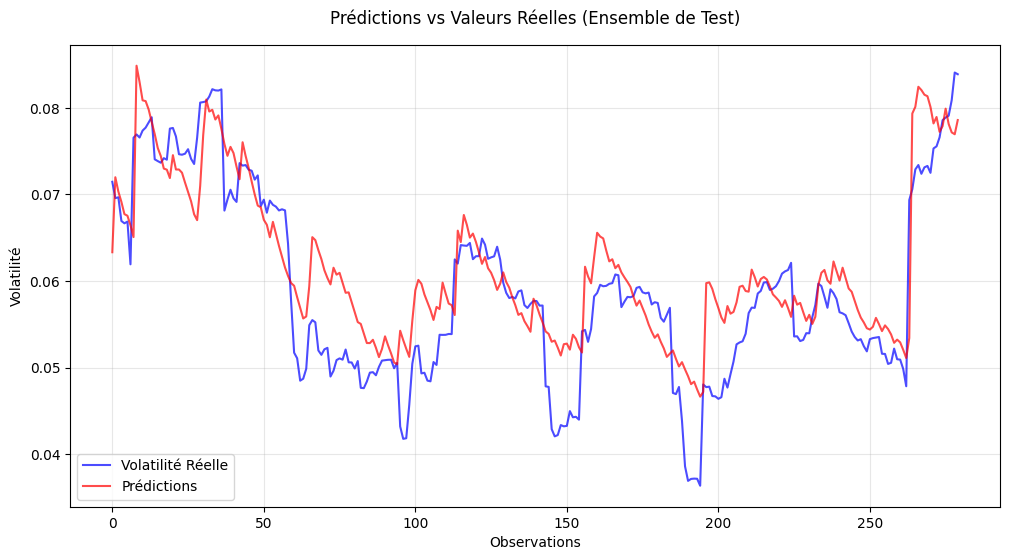

In [74]:
plot_predictions_vs_actual(test_hv_clean, test_gv_clean)

Training set size: 1233
Test set size: 309


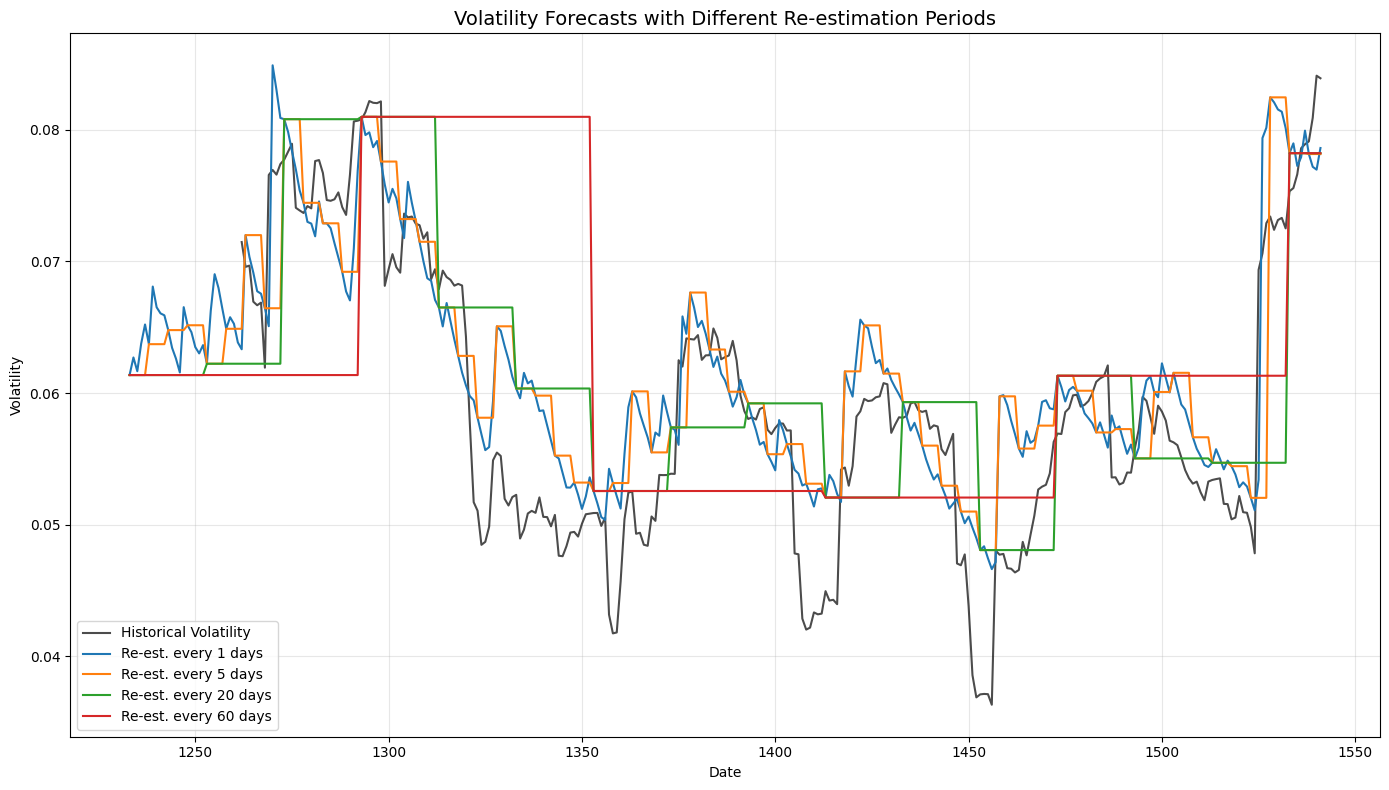


Performance metrics for different re-estimation periods:
             1         5         20        60
MSE    0.000031  0.000040  0.000062  0.000169
MAE    0.004542  0.004985  0.006026  0.009918
Theil  0.045862  0.051632  0.064275  0.105565


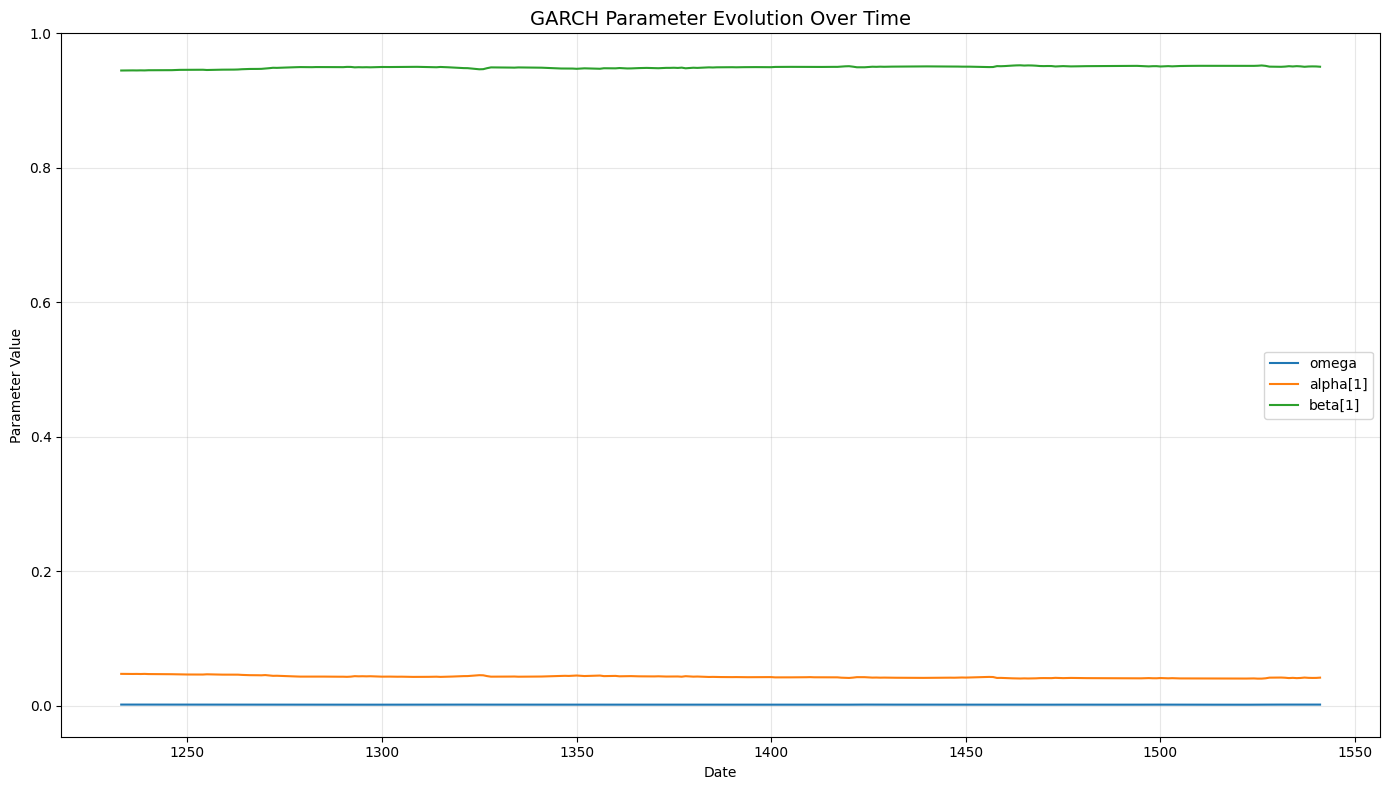

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function for calculating historical volatility
def calculate_historical_volatility(returns, window=30):
    """
    Calculate historical volatility as in Lahmiri's paper
    """
    # Calculate volatility as rolling standard deviation over 30 days
    # and annualize (sqrt(252) is a common annualization factor for daily data)
    hvol = returns.rolling(window=window).std() * np.sqrt(252)
    return hvol

# Function to calculate Theil coefficient
def calculate_theil_coefficient(y_true, y_pred):
    """
    Calculate Theil's inequality coefficient
    """
    numerator = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denominator = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return numerator / denominator

# Function to fit GARCH model
def fit_model(returns, model_type='Garch', distribution='StudentsT', p=1, q=1):
    """
    Fit a GARCH model to return series
    """
    # Remove NA values
    returns = returns.dropna()
    
    # Rescale returns
    scaled_returns = returns * 100
    
    # Configure the model based on type
    if model_type.upper() == 'GJR-GARCH':
        model = arch_model(scaled_returns,
                         vol='GARCH',
                         p=p,
                         q=q,
                         o=1,  # Enable asymmetric term for GJR-GARCH
                         power=2.0,  # Power GARCH with power 2 for GJR-GARCH
                         dist=distribution)
    else:
        model = arch_model(scaled_returns,
                         vol=model_type,
                         p=p,
                         q=q,
                         o=1 if model_type=='EGARCH' else 0,
                         dist=distribution)
    
    # Fit the model
    results = model.fit(disp='off')
    
    # Get volatility forecasts
    volatility = pd.Series(
        np.sqrt(results.conditional_volatility) * np.sqrt(252) / 100,
        index=returns.index
    )
    
    return results, volatility

# Function to forecast volatility with periodic re-estimation
def forecast_with_periodic_reestimation(train_returns, test_returns, model_type='Garch', 
                                        distribution='StudentsT', p=1, q=1, 
                                        reestimation_period=1, initial_window='expanding'):
    """
    Forecast volatility with periodic re-estimation of the model parameters
    
    Parameters:
    -----------
    train_returns : pandas.Series
        Training data for initial model estimation
    test_returns : pandas.Series
        Test data for out-of-sample forecasting
    model_type : str
        GARCH model type ('Garch', 'EGARCH', 'GJR-GARCH')
    distribution : str
        Error distribution ('Normal', 'StudentsT', 'ged')
    p : int
        ARCH order
    q : int
        GARCH order
    reestimation_period : int
        Number of days between model re-estimations (1=daily, 5=weekly, etc.)
    initial_window : str
        'expanding' to use all past data or 'rolling' to use a fixed window
        
    Returns:
    --------
    pandas.Series
        Forecasted volatility for test period
    list
        Model parameters over time
    """
    test_volatility = []
    model_params = []
    
    # Initialize with all training data
    estimation_data = train_returns.copy()
    
    # Loop through test period
    for i in range(len(test_returns)):
        # Re-estimate the model if it's time (or if it's the first iteration)
        if i % reestimation_period == 0 or i == 0:
            # Fit model on current estimation data
            model_result, _ = fit_model(estimation_data, model_type=model_type, 
                                       distribution=distribution, p=p, q=q)
            
            # Store parameters
            params = model_result.params
            model_params.append({
                'date': test_returns.index[i],
                'params': params.to_dict()
            })
            
        # Generate forecast (always using the latest model)
        forecast = model_result.forecast(horizon=1)
        vol = np.sqrt(forecast.variance.iloc[-1, 0]) * np.sqrt(252) / 100
        test_volatility.append(vol)
        
        # Update the estimation data for next iteration
        if initial_window == 'expanding':
            # Add the current day to the estimation window
            estimation_data = pd.concat([estimation_data, test_returns.iloc[i:i+1]])
        elif initial_window == 'rolling':
            # Add the current day and remove the oldest day to maintain window size
            estimation_data = pd.concat([estimation_data, test_returns.iloc[i:i+1]]).iloc[1:]
    
    # Convert to pandas Series
    test_volatility_series = pd.Series(test_volatility, index=test_returns.index)
    
    return test_volatility_series, model_params

# Function to plot parameter evolution over time
def plot_parameter_evolution(model_params, param_names=None):
    """
    Plot how parameters evolve over time during re-estimation
    """
    dates = [p['date'] for p in model_params]
    
    if param_names is None:
        # Use all parameters
        param_names = list(model_params[0]['params'].keys())
    
    plt.figure(figsize=(14, 8))
    
    for param in param_names:
        values = [p['params'].get(param, np.nan) for p in model_params]
        plt.plot(dates, values, label=param)
    
    plt.title('GARCH Parameter Evolution Over Time', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to compare volatility forecasts with different re-estimation periods
def compare_reestimation_periods(train_returns, test_returns, periods=[1, 5, 20, 60], 
                                model_type='Garch', distribution='StudentsT'):
    """
    Compare volatility forecasts with different re-estimation periods
    
    Parameters:
    -----------
    periods : list
        List of re-estimation periods to test (in days)
    """
    results = {}
    
    # Calculate the actual historical volatility for reference
    test_hv = calculate_historical_volatility(test_returns)
    
    plt.figure(figsize=(14, 8))
    plt.plot(test_hv, label='Historical Volatility', color='black', alpha=0.7)
    
    for period in periods:
        # Generate forecasts with the current re-estimation period
        forecast, _ = forecast_with_periodic_reestimation(
            train_returns, 
            test_returns, 
            model_type=model_type,
            distribution=distribution,
            reestimation_period=period
        )
        
        # Calculate metrics (removing NA values)
        mask = ~(test_hv.isna() | forecast.isna())
        
        mse = mean_squared_error(test_hv[mask], forecast[mask])
        mae = mean_absolute_error(test_hv[mask], forecast[mask])
        theil = calculate_theil_coefficient(test_hv[mask].values, forecast[mask].values)
        
        # Store results
        results[period] = {
            'MSE': mse,
            'MAE': mae,
            'Theil': theil,
            'forecast': forecast
        }
        
        # Plot the forecast
        plt.plot(forecast, label=f'Re-est. every {period} days')
    
    plt.title('Volatility Forecasts with Different Re-estimation Periods', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display metrics in a table
    metrics_df = pd.DataFrame({
        period: {
            'MSE': results[period]['MSE'],
            'MAE': results[period]['MAE'],
            'Theil': results[period]['Theil']
        } for period in periods
    })
    
    print("\nPerformance metrics for different re-estimation periods:")
    print(metrics_df)
    
    return results

# Sample usage (assuming df and split point are already defined)
# Load and prepare your data first
try:
    # Assume df is already loaded and contains returns
    df = pd.read_csv("data_macro_romain_processed.csv")
    returns = df['return_eurousd']
    
    # Split into training and test sets (80/20)
    split_point = int(len(returns) * 0.8)
    train_returns = returns.iloc[:split_point]
    test_returns = returns.iloc[split_point:]
    
    print(f"Training set size: {len(train_returns)}")
    print(f"Test set size: {len(test_returns)}")
    
    # Compare different re-estimation periods
    results = compare_reestimation_periods(
        train_returns, 
        test_returns, 
        periods=[1, 5, 20, 60],  # Daily, weekly, monthly, quarterly
        model_type='Garch', 
        distribution='StudentsT'
    )
    
    # Generate forecasts with daily re-estimation and plot parameter evolution
    forecast, model_params = forecast_with_periodic_reestimation(
        train_returns, 
        test_returns,
        reestimation_period=1,  # Daily re-estimation
        model_type='Garch',
        distribution='StudentsT'
    )
    
    # Plot how parameters evolve over time
    # Typically most interesting parameters are omega, alpha, beta
    plot_parameter_evolution(model_params, param_names=['omega', 'alpha[1]', 'beta[1]'])
    
except Exception as e:
    print(f"Error: {e}")
    print("Please run this after loading your data first.")